# QST-CGAN For Reconstructing a Density matrix of Two-Entangled Photons



In [1]:
#import friendly_traceback
import numpy as np
import sys
import os
import qutip
#os.execl(sys.executable, sys.executable, *sys.argv)
#print(os.getcwd())
# Add the path to the qst_cgan directory
sys.path.append(os.path.abspath('/home/aq/qstgan/venv37/qst-cgan/'))
from qutip import  Qobj

import tensorflow as tf

#tf.config.run_functions_eagerly(True)

from tqdm.auto import tqdm

from qst_cgan.ops import convert_to_real_ops, tf_fidelity, dm_to_tf
from qst_cgan.gan import generator_loss, discriminator_loss, Generator, Discriminator


import matplotlib.pyplot as plt


from dataclasses import dataclass

%load_ext autoreload
tf.keras.backend.set_floatx('float64') # Set float64 as the default

2024-12-25 03:05:34.734195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-25 03:05:34.908710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-25 03:05:34.908744: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-25 03:05:35.948843: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

# Construct Measurement Operators

In [2]:
#@Saumya

# Define six 2x1 matrices
matrices = [
    np.array([[1], [0]]),                                # Ket H 
    np.array([[1/np.sqrt(2)], [1j/np.sqrt(2)]]),         # Ket R 
    np.array([[1/np.sqrt(2)], [-1j/np.sqrt(2)]]),        # Ket L 
    np.array([[1/np.sqrt(2)], [1/np.sqrt(2)]]),          # Ket D 
    np.array([[0], [1]]),                                # Ket V
    np.array([[1/np.sqrt(2)], [-1/np.sqrt(2)]])          # Ket A 
]

labels = ['H', 'R', 'L', 'D', 'V', 'A']
seq = np.array([0, 1, 3, 2, 4, 5])
revseq = np.array([5, 4, 2, 3, 1, 0])

# Pre-allocate an array to store 36 projection matrices of size 4x4
opers = np.zeros((36, 4, 4), dtype=complex)

s = 0  # Index to save projection matrices
for i in range(0, 6, 2):
    for j in range(6):
        # Compute the projection matrix
        projection = np.dot(
            np.kron(matrices[i], matrices[seq[j]]),
            np.transpose(np.kron(matrices[i], matrices[seq[j]]))
        )
        opers[s] = projection  # Save the projection matrix in the array
        print(f"Projection number {s + 1} (|{labels[i]}⟩⟨{labels[seq[j]]}|):")
        print(projection)
        s += 1

    i += 1
    for k in range(6):
        # Compute the projection matrix
        projection = np.dot(
            np.kron(matrices[i], matrices[revseq[k]]),
            np.transpose(np.kron(matrices[i], matrices[revseq[k]]))
        )
        opers[s] = projection  # Save the projection matrix in the array
        print(f"Projection number {s + 1} (|{labels[i]}⟩⟨{labels[revseq[k]]}|):")
        print(projection)
        s += 1

# Verify the saved matrices
print("\nSaved projection matrices in 'opers':")
for idx, op in enumerate(opers, start=1):
    print(f"Matrix {idx}:\n{op}\n")
    #print(opers[1,0,0])

Projection number 1 (|H⟩⟨H|):
[[1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Projection number 2 (|H⟩⟨R|):
[[ 0.5+0.j   0. +0.5j  0. +0.j   0. +0.j ]
 [ 0. +0.5j -0.5+0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j ]]
Projection number 3 (|H⟩⟨D|):
[[0.5 0.5 0.  0. ]
 [0.5 0.5 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]
Projection number 4 (|H⟩⟨L|):
[[ 0.5+0.j   0. -0.5j  0. +0.j   0. +0.j ]
 [ 0. -0.5j -0.5+0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j ]]
Projection number 5 (|H⟩⟨V|):
[[0 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Projection number 6 (|H⟩⟨A|):
[[ 0.5 -0.5  0.   0. ]
 [-0.5  0.5  0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]]
Projection number 7 (|R⟩⟨A|):
[[ 0.25+0.j   -0.25+0.j    0.  +0.25j  0.  -0.25j]
 [-0.25+0.j    0.25+0.j    0.  -0.25j  0.  +0.25j]
 [ 0.  +0.25j  0.  -0.25j -0.25+0.j    0.25+0.j  ]
 [ 0.  -0.25j  0.  +0.25j  0.25

# Measurement Data

In [3]:
m_ops = opers
print("Tensor shape:", m_ops.shape)
data_list = [686,348,306,432,10,408,687,414,352,61,395,318,382,288,666,303,309,57,340,398,648,369,67,311,8,333,342,303,725,319,519,33,153,182,571,447]
total_sum = 1429 #sum(data_list)
normalized_data= [y/ total_sum for y in data_list]
#data= torch.tensor(data_list).reshape(1, -1)
data = np.array(normalized_data).reshape(1, -1)
tot_data=data
tot_ops=opers
# Print the NumPy array and its shape
print("total_sum:",total_sum)
print("NumPy Array:", data)
print("Shape:", data.shape)

Tensor shape: (36, 4, 4)
total_sum: 1429
NumPy Array: [[0.48005598 0.24352694 0.21413576 0.30230931 0.0069979  0.28551435
  0.48075577 0.28971309 0.2463261  0.04268719 0.27641707 0.22253324
  0.2673198  0.20153954 0.46606018 0.21203639 0.21623513 0.03988803
  0.23792862 0.27851645 0.45346396 0.25822253 0.04688593 0.21763471
  0.00559832 0.23303009 0.2393282  0.21203639 0.5073478  0.22323303
  0.36319104 0.02309307 0.10706788 0.12736179 0.39958013 0.31280616]]
Shape: (1, 36)


# Change of dimension from 4x4 to 32x32

In [4]:
expanded_opers_real = np.zeros((tot_ops.shape[0], 32, 32))
expanded_opers_imag = np.zeros((tot_ops.shape[0], 32, 32))

for i in range(tot_ops.shape[0]):
    expanded_opers_real[i, :4, :4] = tot_ops[i].real
    expanded_opers_imag[i, :4, :4] = tot_ops[i].imag
    # Combine real and imaginary parts into a single complex array
expanded_opers = expanded_opers_real + 1j * expanded_opers_imag

# Verify the shape and type
print(expanded_opers.dtype)  # Should be complex

print("Expanded Opers Shape",expanded_opers.shape) 
print(expanded_opers[1])  

complex128
Expanded Opers Shape (36, 32, 32)
[[ 0.5+0.j   0. +0.5j  0. +0.j  ...  0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.5j -0.5+0.j   0. +0.j  ...  0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j  ...  0. +0.j   0. +0.j   0. +0.j ]
 ...
 [ 0. +0.j   0. +0.j   0. +0.j  ...  0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j  ...  0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j  ...  0. +0.j   0. +0.j   0. +0.j ]]


# Coverting to TensorFlow Tensors

In [5]:

ops_tf = tf.convert_to_tensor([expanded_opers]) # convert the numpy arrays to complex TensorFlow tensors
print(ops_tf.shape)
#print(ops_tf[0,0])
print("ops_tf shape:", ops_tf.shape,ops_tf.dtype)
A = convert_to_real_ops(ops_tf) # convert the complex-valued numpy matrices to real-valued TensorFlow tensors
print("Shape of A is",A.shape)
print("the first real part of the first operator in A",A[0, :, :, :36])
rho_tf = np.array([[0.47268, -0.046671+0.0359951j, -0.0350205+0.0123738j, 0.0532487+0.387632j],
                       [-0.046671-0.0359951j, 0.0418517, 0.0285187+0.0148695j, 0.0259252-0.0386607j],
                       [-0.0350205-0.0123738j, 0.0285187-0.0148695j, 0.0268008, 0.000990322-0.0147513j],
                       [0.0532487-0.387632j, 0.0259252+0.0386607j, 0.000990322+0.0147513j, 0.458668]])



# Calculate the trace
print("Data type of 'opers':", opers.dtype)
trace_rho = np.trace(rho_tf)
print("Trace of the matrix:", trace_rho)
# Calculate the trace
#print(np.dot(rho_tf,opers[0]))
trace0 = np.trace(np.dot(rho_tf,opers[0]))
trace1 = np.trace(np.dot(rho_tf,opers[4]))
print(opers[0])
print(A[0])
print("The trace of rho*P_HH is:", trace0)#/data[0,0])
print(opers[1])
print("The trace of rho*P_HR is:", trace1)#/data[0,0])


(1, 36, 32, 32)
ops_tf shape: (1, 36, 32, 32) <dtype: 'complex128'>
Shape of A is (1, 32, 32, 72)
the first real part of the first operator in A tf.Tensor(
[[[ 1.    0.5   0.5  ...  0.25  0.25  0.5 ]
  [ 0.    0.    0.5  ...  0.25  0.    0.  ]
  [ 0.    0.    0.   ... -0.25 -0.25 -0.5 ]
  ...
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]]

 [[ 0.    0.    0.5  ...  0.25  0.    0.  ]
  [ 0.   -0.5   0.5  ...  0.25 -0.25  0.  ]
  [ 0.    0.    0.   ... -0.25  0.    0.  ]
  ...
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]]

 [[ 0.    0.    0.   ... -0.25 -0.25 -0.5 ]
  [ 0.    0.    0.   ... -0.25  0.    0.  ]
  [ 0.    0.    0.   ...  0.25  0.25  0.5 ]
  ...
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]]

 ...

 [[ 0.    0.    0.   .

2024-12-25 03:05:37.965606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-25 03:05:37.966194: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-25 03:05:37.966366: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-12-25 03:05:37.966516: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-12-25 03:05:37.966672: W tensorflow/c

# Converting Rho_tf to 32x32

In [6]:
# Initialize a 32x32 complex matrix with zeros
rho_tf32 = np.zeros((32, 32), dtype=np.complex128)

# Assign the 4x4 complex matrix to the top-left corner
rho_tf32[:4, :4] = rho_tf

# Print the resulting 32x32 matrix
print(rho_tf.shape,rho_tf32.shape,rho_tf32)

(4, 4) (32, 32) [[ 0.47268  +0.j        -0.046671 +0.0359951j -0.0350205+0.0123738j ...
   0.       +0.j         0.       +0.j         0.       +0.j       ]
 [-0.046671 -0.0359951j  0.0418517+0.j         0.0285187+0.0148695j ...
   0.       +0.j         0.       +0.j         0.       +0.j       ]
 [-0.0350205-0.0123738j  0.0285187-0.0148695j  0.0268008+0.j        ...
   0.       +0.j         0.       +0.j         0.       +0.j       ]
 ...
 [ 0.       +0.j         0.       +0.j         0.       +0.j        ...
   0.       +0.j         0.       +0.j         0.       +0.j       ]
 [ 0.       +0.j         0.       +0.j         0.       +0.j        ...
   0.       +0.j         0.       +0.j         0.       +0.j       ]
 [ 0.       +0.j         0.       +0.j         0.       +0.j        ...
   0.       +0.j         0.       +0.j         0.       +0.j       ]]


# Training the CGAN

In [7]:
hilbert_size=32
#x=tot_data
x= tf.convert_to_tensor(tot_data.reshape(1, -1))
x= tf.cast(x, dtype=tf.float64)
print(type(x)) 
print(f"Dtype: {x.dtype}")
print("Tensor shape:", x.shape)
num_measurements = x.shape[-1]
#tf.print("Dynamic num_measurementss:", tf.shape(x)[-1])

generator = Generator(hilbert_size, num_measurements, noise=0.0) # Specify the number of measurement settings and Gaussian noise
discriminator = Discriminator(hilbert_size, num_measurements)

<class 'tensorflow.python.framework.ops.EagerTensor'>
Dtype: <dtype: 'float64'>
Tensor shape: (1, 36)


# Density Matrix Layer

In [8]:
density_layer_idx = None

for i, layer in enumerate(generator.layers):
    if "density_matrix" in layer._name:
        density_layer_idx = i
       # breakgetcwd

print(density_layer_idx)
model_dm = tf.keras.Model(inputs=generator.input, outputs=generator.layers[density_layer_idx].output)

@dataclass
class LossHistory:
    """Class for keeping track of loss"""
    generator: list
    discriminator: list
    l1: list

loss = LossHistory([], [], [])
fidelities = []

17


# Training

In [9]:
initial_learning_rate = 0.000075
#lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate)
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate,
                                                     decay_steps=100,
                                                     decay_rate=0.96,
                                                     staircase=False)  

lam =100.

generator_optimizer = tf.keras.optimizers.Adam(lr_schedule, 0.5, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule, 0.5, 0.5)

max_iterations=5000

# Reconstruction

In [10]:
def train_step(A, x):
    """Takes one step of training for the full A matrix representing the
    measurement operators and data x.

    Note that the `generator`, `discriminator`, `generator_optimizer` and the
    `discriminator_optimizer` has to be defined before calling this function.

    Args:
        A (tf.Tensor): A tensor of shape (m, hilbert_size, hilbert_size, n x 2)
                       where m=1 for a single reconstruction, and n represents
                       the number of measured operators. We split the complex
                       operators as real and imaginary in the last axis. The 
                       helper function `convert_to_real_ops` can be used to
                       generate the matrix A with a set of complex operators
                       given by `ops` with shape (1, n, hilbert_size, hilbert_size)
                       by calling `A = convert_to_real_ops(ops)`.

        x (tf.Tensor): A tensor of shape (m, n) with m=1 for a single
                       reconstruction and `n` representing the number of
                       measurements. 
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator([A, x], training=True)
        
        
        disc_real_output = discriminator([A, x, x], training=True)
        disc_generated_output = discriminator([A, x, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, x, lam=lam
        )
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables
    )
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables)
    )

    loss.generator.append(gen_gan_loss)
    loss.l1.append(gen_l1_loss)
    loss.discriminator.append(disc_loss)


pbar = tqdm(range(max_iterations))

#rho_tf = np.loadtxt("/home/aq/Downloads/DensityMatrix.csv", delimiter=",")
#print(rho_tf)

# Use the density matrix from MLE to compare


for i in pbar:
    train_step(A, x)
    density_matrix = model_dm([A, x])
    f = tf_fidelity(density_matrix, rho_tf32)[-1]
    fidelities.append(f)
    pbar.set_description("Fidelity {} | Gen loss {} | L1 loss {} | Disc loss {}".format(f, loss.generator[-1], loss.l1[-1], loss.discriminator[-1]))
    

  0%|          | 0/5000 [00:00<?, ?it/s]

Fidelity 0.3996852368103471 | Gen loss 0.6940598060460816 | L1 loss 0.11553533685021367 | Disc loss 1.3844192427952018:   3%|▎         | 145/5000 [00:35<19:43,  4.10it/s] 


KeyboardInterrupt: 

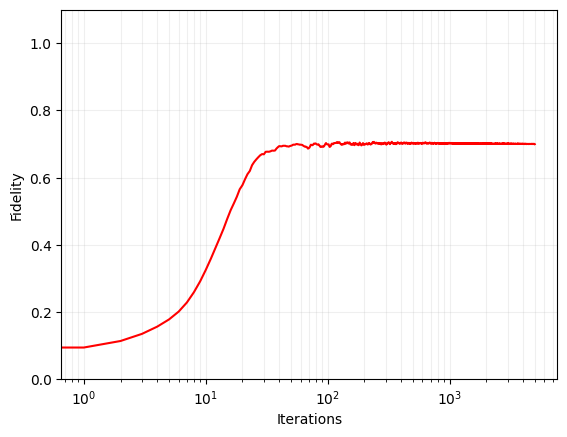

In [ ]:
iterations = np.arange(len(fidelities))
plt.plot(iterations, fidelities, color="red", label="QST-CGAN")
plt.xlabel("Iterations")
plt.ylabel("Fidelity")
plt.ylim(0, 1.1)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.2)
plt.xscale('log')
plt.show()